In [1]:
!pip install stable-baselines3[extra] gymnasium scikit-learn pandas matplotlib seaborn xlrd openpyxl -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gymnasium as gym
from gymnasium import spaces
from typing import Optional, Dict, Tuple

class ConcreteMixEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data_path: str = 'Concrete Compressive Strength Concrete_Data Augmented with GWP Information_Published.xlsx', render_mode: Optional[str] = None):
        super().__init__()

        # Load and validate data
        try:
            data = pd.read_excel(data_path)
            required_columns = ['Cement', 'Blast_Furnace_Slag', 'Fly_Ash', 'Water',
                               'Superplasticizer', 'Coarse_Aggregate', 'Fine_Aggregate', 'Age',
                               'Compressive_Strength', 'Global_Warming_Potential']
            if not all(col in data.columns for col in required_columns):
                raise ValueError("Data is missing required columns")
        except Exception as e:
            raise ValueError(f"Error loading data: {str(e)}")

        # Store data and feature names
        self.X = data[required_columns[:-2]].copy()
        self.y_strength = data['Compressive_Strength'].copy()
        self.y_gwp = data['Global_Warming_Potential'].copy()
        self.feature_names = self.X.columns.tolist()

        # Train surrogate models with proper feature names
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(self.X)  # Keeps feature names

        # Train strength model
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y_strength, test_size=0.2, random_state=42)
        self.strength_model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.strength_model.fit(X_train, y_train)

        # Train GWP model
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y_gwp, test_size=0.2, random_state=42)
        self.gwp_model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.gwp_model.fit(X_train, y_train)

        # Define spaces
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(len(self.feature_names),), dtype=np.float32)

        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(len(self.feature_names) + 2,), dtype=np.float32)

        # Initialize state
        self.current_mix = None
        self.current_strength = None
        self.current_gwp = None
        self.render_mode = render_mode

    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict]:
        super().reset(seed=seed)

        # Start with random valid mix
        idx = self.np_random.integers(0, len(self.X))
        self.current_mix = self.X.iloc[idx].values
        self.current_strength = self.y_strength.iloc[idx]
        self.current_gwp = self.y_gwp.iloc[idx]

        info = {
            'mix': self.current_mix.copy(),
            'strength': self.current_strength,
            'gwp': self.current_gwp
        }
        return self._get_obs(), info

    def _get_obs(self) -> np.ndarray:
        return np.concatenate([
            self.current_mix,
            [self.current_strength],
            [self.current_gwp]
        ])

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        # Validate action
        if not isinstance(action, np.ndarray) or action.shape != (len(self.feature_names),):
            raise ValueError(f"Action must be numpy array of shape ({len(self.feature_names)},)")

        # Apply action (percentage change to each component)
        action = np.clip(action, -1.0, 1.0) * 0.1  # Limit to ±10% change
        new_mix = self.current_mix * (1 + action)
        new_mix = np.maximum(new_mix, 0)  # Ensure non-negative

        # Create DataFrame for proper scaling with feature names
        new_mix_df = pd.DataFrame([new_mix], columns=self.feature_names)
        scaled_mix = self.scaler.transform(new_mix_df)

        # Predict properties
        new_strength = self.strength_model.predict(scaled_mix)[0]
        new_gwp = self.gwp_model.predict(scaled_mix)[0]

        # Calculate reward (maximize strength, minimize GWP)
        reward = (new_strength / self.y_strength.max()) - (new_gwp / self.y_gwp.max())

        # Update state
        self.current_mix = new_mix
        self.current_strength = new_strength
        self.current_gwp = new_gwp

        # Additional info
        info = {
            'strength': new_strength,
            'gwp': new_gwp,
            'mix': new_mix.copy()
        }

        return self._get_obs(), reward, False, False, info

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
import os

def make_env(data_path: str = 'Concrete Compressive Strength Concrete_Data Augmented with GWP Information_Published.xlsx', rank: int = 0) -> callable:
    """Environment creation function for parallel training"""
    def _init() -> ConcreteMixEnv:
        env = ConcreteMixEnv(data_path)
        return env
    return _init

def setup_training(data_path: str = 'Concrete Compressive Strength Concrete_Data Augmented with GWP Information_Published.xlsx') -> PPO:
    """Configure and return PPO model with proper environment setup"""
    # Create vectorized environment (4 parallel instances)
    vec_env = make_vec_env(make_env(data_path), n_envs=4)

    # Create evaluation environment
    eval_env = ConcreteMixEnv(data_path)

    # Setup evaluation callback
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path='./best_model/',
        log_path='./logs/',
        eval_freq=5000,
        deterministic=True,
        render=False
    )

    # Create PPO model
    model = PPO(
        "MlpPolicy",
        vec_env,
        verbose=1,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        tensorboard_log="./ppo_tensorboard/"
    )

    return model, eval_callback

def train_model(model: PPO, callback: EvalCallback, total_timesteps: int = 10000) -> PPO:
    """Train the model with proper logging and saving"""
    # Create necessary directories
    os.makedirs("./best_model/", exist_ok=True)
    os.makedirs("./logs/", exist_ok=True)
    os.makedirs("./ppo_tensorboard/", exist_ok=True)

    # Train the model
    model.learn(
        total_timesteps=total_timesteps,
        callback=callback,
        progress_bar=True
    )

    # Save the final model
    model.save("concrete_mix_ppo_final")
    return model

# Execute training
if __name__ == "__main__":
    model, callback = setup_training()
    trained_model = train_model(model, callback)

Using cpu device
Logging to ./ppo_tensorboard/PPO_1


Output()

-----------------------------
| time/              |      |
|    fps             | 61   |
|    iterations      | 1    |
|    time_elapsed    | 132  |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 2           |
|    time_elapsed         | 401         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.010968104 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | 0.0981      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00856    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0099     |
|    std                  | 1.01        |
|    value_loss           | 1.16        |
----------------------------------

In [4]:
def generate_optimized_mixes(model_path: str = "concrete_mix_ppo_final",
                           data_path: str = 'Concrete Compressive Strength Concrete_Data Augmented with GWP Information_Published.xlsx',
                           n_mixes: int = 7000,
                           optimization_steps: int = 20) -> pd.DataFrame:
    """Generate optimized concrete mixes using trained model"""
    # Load model and environment
    model = PPO.load(model_path)
    env = ConcreteMixEnv(data_path)
    feature_names = env.feature_names

    optimized_mixes = []

    for _ in range(n_mixes):
        obs, _ = env.reset()

        # Optimization steps
        for _ in range(optimization_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, _, _, _, _ = env.step(action)

        # Create DataFrame row with proper feature names
        mix_dict = {name: value for name, value in zip(feature_names, env.current_mix)}
        mix_dict.update({
            'Compressive_Strength': env.current_strength,
            'GWP': env.current_gwp
        })
        optimized_mixes.append(mix_dict)

    # Convert to DataFrame
    mixes_df = pd.DataFrame(optimized_mixes)

    # Filter invalid mixes
    valid_mixes = mixes_df[
        (mixes_df[feature_names] > 0).all(axis=1) &
        (mixes_df['Water'] > 80) &
        (mixes_df['Cement'] + mixes_df['Blast_Furnace_Slag'] +
         mixes_df['Fly_Ash'] > 180) &
        (mixes_df['GWP'] < 400)
    ].copy()

    # Calculate additional useful metrics
    valid_mixes['Water_to_Cement_Ratio'] = valid_mixes['Water'] / valid_mixes['Cement']
    valid_mixes['Binder_Content'] = (
        valid_mixes['Cement'] +
        valid_mixes['Blast_Furnace_Slag'] +
        valid_mixes['Fly_Ash']
    )

    return valid_mixes.sort_values(
        by=['Compressive_Strength', 'GWP'],
        ascending=[False, True]
    )

# Example usage
if __name__ == "__main__":
    best_mixes = generate_optimized_mixes()
    print(f"Generated {len(best_mixes)} valid mixes")
    best_mixes.to_csv('optimized_concrete_mixes_rl_debugged.csv', index=False)

Generated 1536 valid mixes


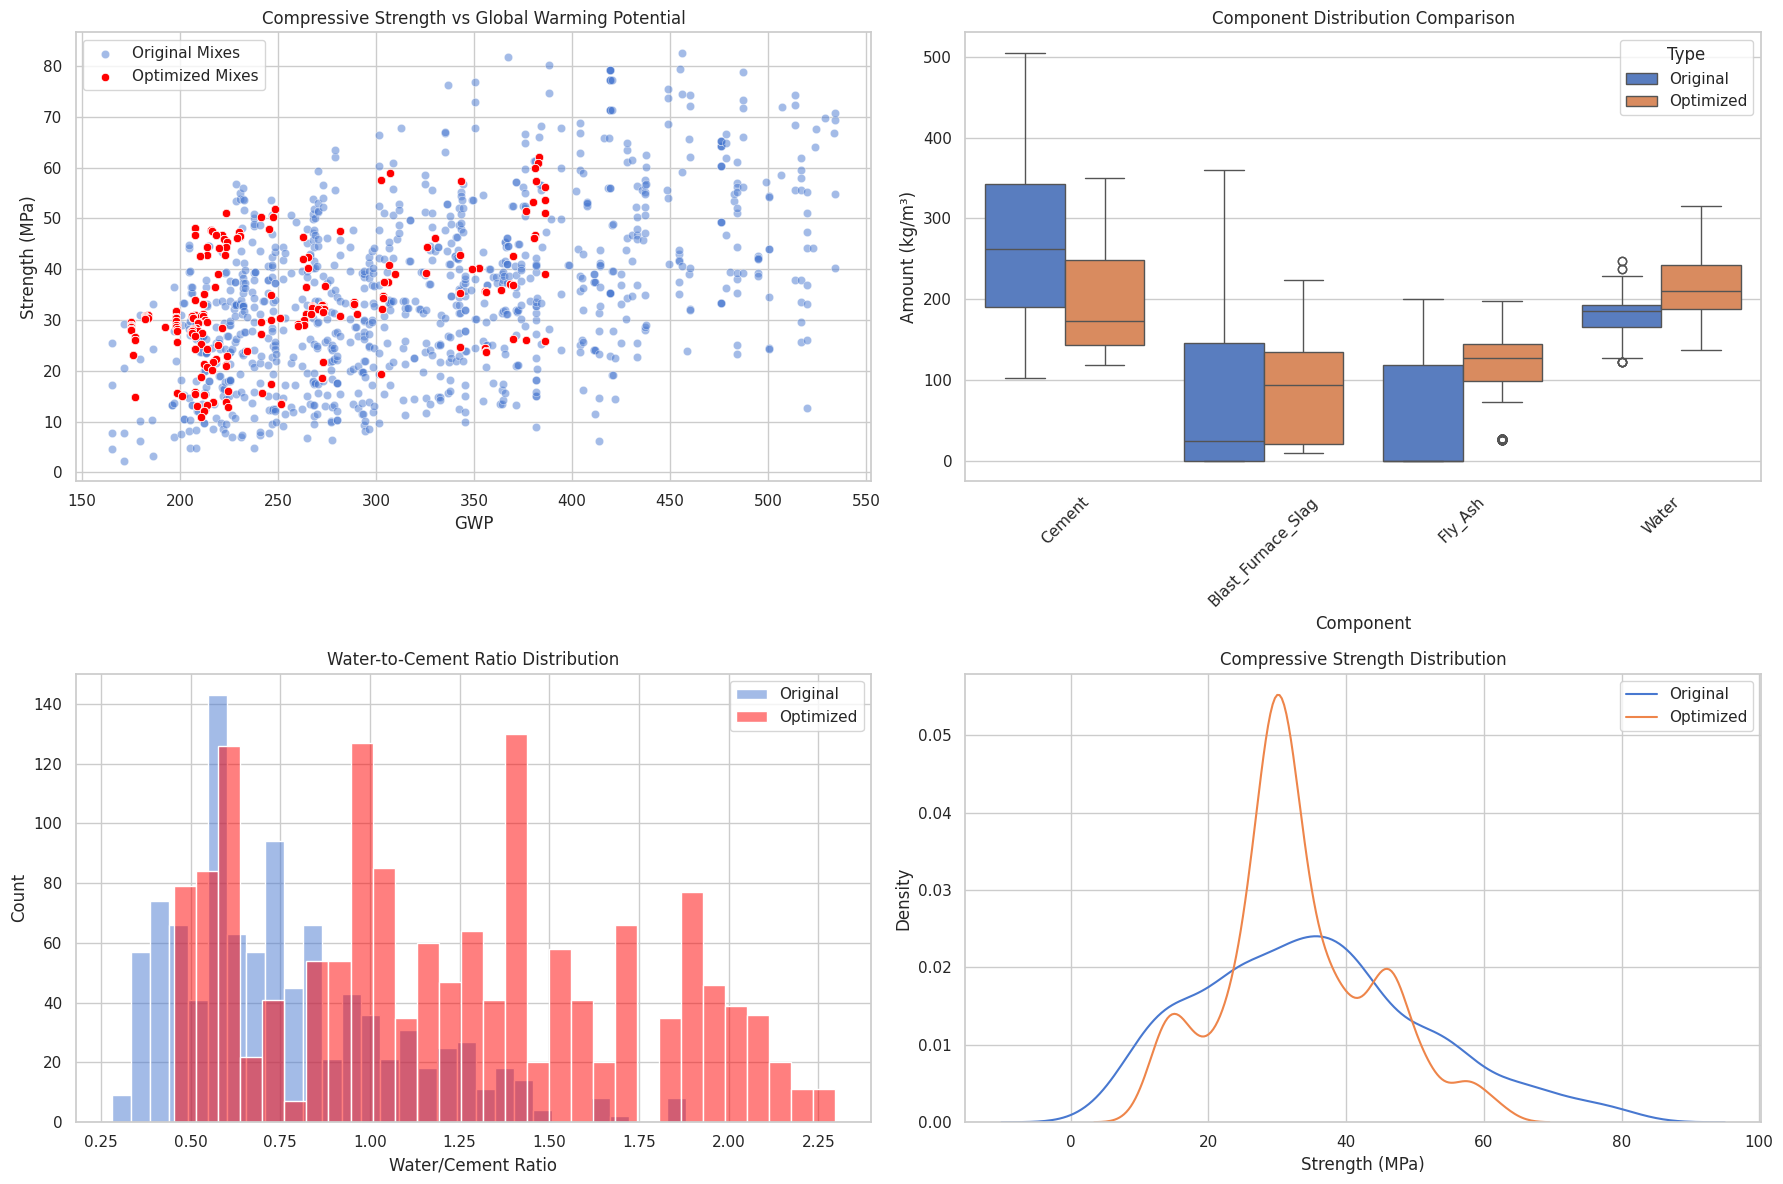


Original Mixes Statistics:
Average Strength: 35.24 MPa
Average GWP: 324.33

Optimized Mixes Statistics:
Average Strength: 32.99 MPa
Average GWP: 257.18
Top 5% Strength: 51.50 MPa
Bottom 5% GWP: 176.95


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(original_path: str = 'Concrete Compressive Strength Concrete_Data Augmented with GWP Information_Published.xlsx',
                   optimized_path: str = 'optimized_concrete_mixes_rl_debugged.csv'):
    """Compare original and optimized mixes with visualizations"""
    # Load data
    original = pd.read_excel(original_path)
    optimized = pd.read_csv(optimized_path)

    # Set up plots
    plt.figure(figsize=(18, 12))
    sns.set(style='whitegrid', palette='muted')

    # Plot 1: Strength vs GWP comparison
    plt.subplot(2, 2, 1)
    sns.scatterplot(x='Global_Warming_Potential', y='Compressive_Strength',
                   data=original, alpha=0.5, label='Original Mixes')
    sns.scatterplot(x='GWP', y='Compressive_Strength',
                   data=optimized, color='red', label='Optimized Mixes')
    plt.title('Compressive Strength vs Global Warming Potential')
    plt.xlabel('GWP')
    plt.ylabel('Strength (MPa)')
    plt.legend()

    # Plot 2: Component distributions
    plt.subplot(2, 2, 2)
    components = ['Cement', 'Blast_Furnace_Slag', 'Fly_Ash', 'Water']
    original_melt = original[components].melt(var_name='Component', value_name='Amount')
    optimized_melt = optimized[components].melt(var_name='Component', value_name='Amount')
    original_melt['Type'] = 'Original'
    optimized_melt['Type'] = 'Optimized'
    combined = pd.concat([original_melt, optimized_melt])

    sns.boxplot(x='Component', y='Amount', hue='Type', data=combined)
    plt.title('Component Distribution Comparison')
    plt.ylabel('Amount (kg/m³)')
    plt.xticks(rotation=45)

    # Plot 3: Water-to-Cement Ratio
    plt.subplot(2, 2, 3)
    sns.histplot(data=original, x=original['Water']/original['Cement'],
                bins=30, alpha=0.5, label='Original')
    sns.histplot(data=optimized, x=optimized['Water_to_Cement_Ratio'],
                bins=30, color='red', alpha=0.5, label='Optimized')
    plt.title('Water-to-Cement Ratio Distribution')
    plt.xlabel('Water/Cement Ratio')
    plt.legend()

    # Plot 4: Strength distribution
    plt.subplot(2, 2, 4)
    sns.kdeplot(data=original, x='Compressive_Strength', label='Original')
    sns.kdeplot(data=optimized, x='Compressive_Strength', label='Optimized')
    plt.title('Compressive Strength Distribution')
    plt.xlabel('Strength (MPa)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('concrete_mix_optimization_comparison.png', dpi=600)
    plt.show()

    # Print key statistics
    print("\nOriginal Mixes Statistics:")
    print(f"Average Strength: {original['Compressive_Strength'].mean():.2f} MPa")
    print(f"Average GWP: {original['Global_Warming_Potential'].mean():.2f}")

    print("\nOptimized Mixes Statistics:")
    print(f"Average Strength: {optimized['Compressive_Strength'].mean():.2f} MPa")
    print(f"Average GWP: {optimized['GWP'].mean():.2f}")
    print(f"Top 5% Strength: {optimized['Compressive_Strength'].quantile(0.95):.2f} MPa")
    print(f"Bottom 5% GWP: {optimized['GWP'].quantile(0.05):.2f}")

# Execute analysis
if __name__ == "__main__":
    analyze_results()